<a href="https://colab.research.google.com/github/lukzink3/final-IA/blob/main/Neural_Symbolic_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Symbolic Learner# NeuralSymbolic - Demo

In [ ]:
!pip install keras-rectified-adam keras.utils tqdm numpy pandas scikit-learn tensorflow==2.10.0 matplotlib keras-radam keras pydot graphviz

In [ ]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
import tensorflow as tf # Import tensorflow
tf.compat.v1.disable_eager_execution()
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate # Use tensorflow.keras.layers
from keras.losses import binary_crossentropy # Use tensorflow.keras.losses
from keras.utils import plot_model # Use tensorflow.keras.utils
from keras_radam import RAdam
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
from tensorflow.python.keras import backend as K
import tensorflow as tf
import numpy as np
import random
import os

seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


## Import Data from CSV

In [ ]:
df = pd.read_csv('1-25.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,2,2,long,openrect,1,rectanglod,2,short,openrect,...,1,0,0,0,0,0,0,0,0,west
1,4,2,2,short,openrect,2,circlelod,2,short,NaN,...,0,0,0,0,0,1,0,0,0,west
2,4,3,2,short,openrect,1,trianglod,2,short,openrect,...,1,0,1,0,0,0,0,0,0,west
3,5,4,2,short,slopetop,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
4,4,3,2,short,closedrect,1,trianglod,2,short,NaN,...,0,0,1,0,0,1,0,0,0,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5,3,2,long,openrect,3,rectanglod,2,short,hexagon,...,0,0,1,1,0,1,0,0,0,east
71,3,2,2,short,hexagon,2,circlelod,2,long,closedrect,...,0,0,1,0,0,0,0,0,0,east
72,3,1,2,short,slopetop,1,circlelod,3,long,closedrect,...,0,0,1,0,0,0,0,0,0,east
73,3,0,2,short,slopetop,1,trianglod,2,short,openrect,...,0,0,0,1,0,0,0,0,0,east


In [ ]:
# path to the data
path = "1-25.csv"
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped', 'closedtrap',
          'dblclosedrect'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod', 'losanglod',
                 'squareglod', 'diamondlod'],
  'Class_attribute': ['west','east']
}


def read_data(path=path):
    df = pd.read_csv(path)

    for k in df:
        for att in str_att:
            if k.startswith(att):
                for i, val in enumerate(df[k]):
                    if val in str_att[att]:
                        df[k][i] = str_att[att].index(val)

    df.replace("\\0", 0, inplace=True)
    df.replace("None", -1, inplace=True)
    df.fillna(-1, inplace=True)

    return df


df = read_data()
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,2,2,1,6,1,2,2,0,6,...,1,0,0,0,0,0,0,0,0,0
1,4,2,2,0,6,2,0,2,0,-1,...,0,0,0,0,0,1,0,0,0,0
2,4,3,2,0,6,1,3,2,0,6,...,1,0,1,0,0,0,0,0,0,0
3,5,4,2,0,8,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
4,4,3,2,0,0,1,3,2,0,-1,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5,3,2,1,6,3,2,2,0,4,...,0,0,1,1,0,1,0,0,0,1
71,3,2,2,0,4,2,0,2,1,0,...,0,0,1,0,0,0,0,0,0,1
72,3,1,2,0,8,1,0,3,1,0,...,0,0,1,0,0,0,0,0,0,1
73,3,0,2,0,8,1,3,2,0,6,...,0,0,0,1,0,0,0,0,0,1


## Question 1.

Implemente uma solução que implemente proposicionalização com 32 neurônios
de entrada e uma única saída (denotando leste).

In [ ]:
df = read_data()
Y = np.array(df.pop('Class_attribute'))
X = np.array(df)
X

array([[4, 2, 2, ..., 0, 0, 0],
       [4, 2, 2, ..., 0, 0, 0],
       [4, 3, 2, ..., 0, 0, 0],
       ...,
       [3, 1, 2, ..., 0, 0, 0],
       [3, 0, 2, ..., 0, 0, 0],
       [4, 3, 2, ..., 0, 0, 0]], dtype=object)

### Akin Propositionalization Model

In [ ]:
# define model
def model_1():
    model = Sequential(
        [
            Dense(9, activation="relu", input_shape=(len(df.keys()),)),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        loss=binary_crossentropy, optimizer=RAdam(), metrics=["mse", "binary_accuracy"]
    )
    return model


es = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=1000, verbose=1
)

model = model_1()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 297       
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


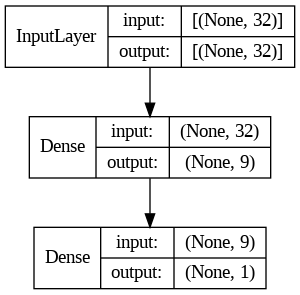

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Train

In [ ]:
# train
leaveOneOut = LeaveOneOut()
hists = dict()
question_1_names = ["Train", "Output of flat network", " Desired output", "Class"]
question_1 = {name: [] for name in question_1_names}

for i, (train, test) in tqdm.tqdm(enumerate(leaveOneOut.split(X)), total=10):

    # Handle NaN values by replacing them with a suitable value (e.g., 0)
    x_train = np.nan_to_num(np.asarray(X[train])).astype(float)
    y_train = np.nan_to_num(np.asarray(Y[train])).astype(float)
    x_test = np.nan_to_num(np.asarray(X[test])).astype(float)
    y_test = np.nan_to_num(np.asarray(Y[test])).astype(float)

    model = model_1()
    hist = model.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=1,
        verbose=1,
    )
    hists[test[0]] = hist

    question_1["Train"].append(i)
    question_1["Output of flat network"].append(model.predict(x_test)[0][0])
    question_1[" Desired output"].append(y_test[0])
    question_1["Class"].append(str_att["Class_attribute"][int(y_test)])

  0%|          | 0/10 [00:00<?, ?it/s]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 2s 31ms/sample - loss: 1.5330 - mse: 0.4987 - binary_accuracy: 0.3378 - val_loss: 2.2567 - val_mse: 0.8016 - val_binary_accuracy: 0.0000e+00


 10%|█         | 1/10 [00:10<01:31, 10.20s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 40ms/sample - loss: 0.8074 - mse: 0.2920 - binary_accuracy: 0.4595 - val_loss: 0.1981 - val_mse: 0.0323 - val_binary_accuracy: 1.0000


 20%|██        | 2/10 [00:23<01:37, 12.22s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 0.8048 - mse: 0.2714 - binary_accuracy: 0.6486 - val_loss: 0.1708 - val_mse: 0.0246 - val_binary_accuracy: 1.0000


 30%|███       | 3/10 [00:36<01:28, 12.60s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 2.3026 - mse: 0.3355 - binary_accuracy: 0.6622 - val_loss: 0.0077 - val_mse: 5.9115e-05 - val_binary_accuracy: 1.0000


 40%|████      | 4/10 [00:49<01:16, 12.79s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 1.2878 - mse: 0.3156 - binary_accuracy: 0.6622 - val_loss: 0.0410 - val_mse: 0.0016 - val_binary_accuracy: 1.0000


 50%|█████     | 5/10 [01:03<01:04, 12.89s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 0.7563 - mse: 0.2751 - binary_accuracy: 0.4865 - val_loss: 0.6862 - val_mse: 0.2465 - val_binary_accuracy: 1.0000


 60%|██████    | 6/10 [01:16<00:51, 12.92s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 0.8968 - mse: 0.3005 - binary_accuracy: 0.5676 - val_loss: 0.1412 - val_mse: 0.0173 - val_binary_accuracy: 1.0000


 70%|███████   | 7/10 [01:29<00:38, 12.95s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 42ms/sample - loss: 0.8540 - mse: 0.3052 - binary_accuracy: 0.5000 - val_loss: 1.0586 - val_mse: 0.4265 - val_binary_accuracy: 0.0000e+00


 80%|████████  | 8/10 [01:42<00:25, 12.96s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 1.6690 - mse: 0.5356 - binary_accuracy: 0.3378 - val_loss: 2.8081 - val_mse: 0.8830 - val_binary_accuracy: 0.0000e+00


 90%|█████████ | 9/10 [01:54<00:12, 12.97s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 40ms/sample - loss: 3.0087 - mse: 0.6385 - binary_accuracy: 0.3378 - val_loss: 5.1094 - val_mse: 0.9880 - val_binary_accuracy: 0.0000e+00


100%|██████████| 10/10 [02:08<00:00, 12.98s/it]

Train on 74 samples, validate on 1 samples
74/74 [==============================] - 3s 41ms/sample - loss: 1.0601 - mse: 0.3837 - binary_accuracy: 0.3919 - val_loss: 1.0451 - val_mse: 0.4203 - val_binary_accuracy: 0.0000e+00


11it [02:21, 12.99s/it]                        

Train on 74 samples, validate on 1 samples


11it [02:29, 13.61s/it]


KeyboardInterrupt: 

### Results

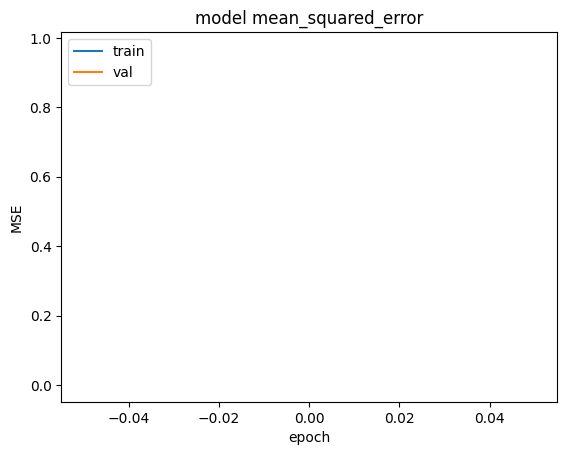

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


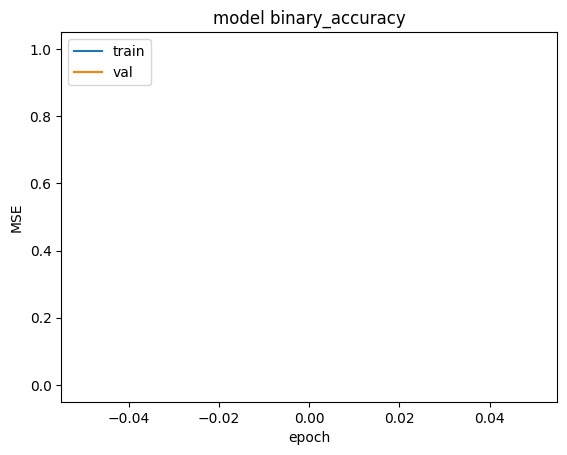

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
train_1 = pd.DataFrame.from_dict(question_1).round(2)
train_1


,Train,Output of flat network,Desired output,Class
0,0,0.74,0.0,west
1,1,0.74,0.0,west
2,2,0.81,0.0,west
3,3,0.97,0.0,west
4,4,0.39,0.0,west
...,...,...,...,...
70,70,0.99,1.0,east
71,71,0.35,1.0,east
72,72,0.79,1.0,east
73,73,0.59,1.0,east


## Question 2.

Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das paginas 136 e 137:

### metanet

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

In [ ]:
def model_2():
    # features
    t = Input(shape=(1,), name="t")
    c = Input(shape=(1,), name="c")
    w = Input(shape=(1,), name="w")
    l = Input(shape=(1,), name="l")
    s = Input(shape=(1,), name="s")
    nc = Input(shape=(1,), name="nc")
    ls = Input(shape=(1,), name="ls")
    nl = Input(shape=(1,), name="nl")
    ncl = Input(shape=(1,), name="ncl")
    x_crc = Input(shape=(1,), name="x_crc")
    x_hex = Input(shape=(1,), name="x_hex")
    x_rec = Input(shape=(1,), name="x_rec")
    x_tri = Input(shape=(1,), name="x_tri")

    # num_cars(t,nc)
    num_cars_ = concatenate([t, nc])
    num_cars_ = Dense(20, activation="relu")(num_cars_)
    num_cars = Dense(1, activation="sigmoid", name="num_cars")(num_cars_)
    num_cars = Model(inputs=[t, nc], outputs=num_cars)

    # num_loads(t,nl)
    num_loads_ = concatenate([t, nl])
    num_loads_ = Dense(20, activation="relu")(num_loads_)
    num_loads = Dense(1, activation="sigmoid", name="num_loads")(num_loads_)
    num_loads = Model(inputs=[t, nl], outputs=num_loads)

    # num_wheels(t,c,w)
    num_wheels_ = concatenate([t, c, w])
    num_wheels_ = Dense(20, activation="relu")(num_wheels_)
    num_wheels = Dense(1, activation="sigmoid", name="num_wheels")(num_wheels_)
    num_wheels = Model(inputs=[t, c, w], outputs=num_wheels)

    # length(t,c,l)
    length_ = concatenate([t, c, l])
    length_ = Dense(20, activation="relu")(length_)
    length = Dense(1, activation="sigmoid", name="length")(length_)
    length = Model(inputs=[t, c, l], outputs=length)

    # shape(t,c,s)
    shape_ = concatenate([t, c, s])
    shape_ = Dense(20, activation="relu")(shape_)
    shape = Dense(1, activation="sigmoid", name="shape")(shape_)
    shape = Model(inputs=[t, c, s], outputs=shape)

    # num_car_loads(t,c,ncl)
    num_car_loads_ = concatenate([t, c, ncl])
    num_car_loads_ = Dense(20, activation="relu")(num_car_loads_)
    num_car_loads = Dense(1, activation="sigmoid", name="num_car_loads")(num_car_loads_)
    num_car_loads = Model(inputs=[t, c, ncl], outputs=num_car_loads)

    # load_shape(t,c,ls)
    load_shape_ = concatenate([t, c, ls])
    load_shape_ = Dense(20, activation="relu")(load_shape_)
    load_shape = Dense(1, activation="sigmoid", name="load_shape")(load_shape_)
    load_shape = Model(inputs=[t, c, ls], outputs=load_shape)

    # next_crc(t,c,x)
    next_crc_ = concatenate([t, c, x_crc])
    next_crc_ = Dense(20, activation="relu")(next_crc_)
    next_crc = Dense(1, activation="sigmoid", name="next_crc")(next_crc_)
    next_crc = Model(inputs=[t, c, x_crc], outputs=next_crc)

    # next_hex_(t,c,x)
    next_hex_ = concatenate([t, c, x_hex])
    next_hex_ = Dense(20, activation="relu")(next_hex_)
    next_hex = Dense(1, activation="sigmoid", name="next_hex")(next_hex_)
    next_hex = Model(inputs=[t, c, x_hex], outputs=next_hex)

    # next_rec(t,c,x)
    next_rec_ = concatenate([t, c, x_rec])
    next_rec_ = Dense(20, activation="relu")(next_rec_)
    next_rec = Dense(1, activation="sigmoid", name="next_rec")(next_rec_)
    next_rec = Model(inputs=[t, c, x_rec], outputs=next_rec)

    # next_tri(t,c,x)
    next_tri_ = concatenate([t, c, x_tri])
    next_tri_ = Dense(20, activation="relu")(next_tri_)
    next_tri = Dense(1, activation="sigmoid", name="next_tri")(next_tri_)
    next_tri = Model(inputs=[t, c, x_tri], outputs=next_tri)

    # east
    east = concatenate(
        [
            num_cars_,
            num_loads_,
            num_wheels_,
            length_,
            shape_,
            num_car_loads_,
            load_shape_,
            next_crc_,
            next_hex_,
            next_rec_,
            next_tri_,
        ]
    )
    east = Dense(3, activation="relu")(east)
    east = Dense(1, activation="sigmoid", name="east")(east)
    east = Model(
        inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri],
        outputs=east,
    )

    # metanet
    metanet = Model(
        inputs=east.inputs,
        outputs=[
            num_cars.output,
            num_loads.output,
            num_wheels.output,
            length.output,
            shape.output,
            num_car_loads.output,
            load_shape.output,
            next_crc.output,
            next_hex.output,
            next_rec.output,
            next_tri.output,
            east.output,
        ],
    )

    # rules
    rules = {
        "num_cars": num_cars,
        "num_loads": num_loads,
        "num_wheels": num_wheels,
        "length": length,
        "shape": shape,
        "num_car_loads": num_car_loads,
        "load_shape": load_shape,
        "next_crc": next_crc,
        "next_hex": next_hex,
        "next_rec": next_rec,
        "next_tri": next_tri,
    }

    return metanet, east, rules


metanet, east, rules = model_2()
metanet.summary()


Model: "model_127"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 nc (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 nl (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                          

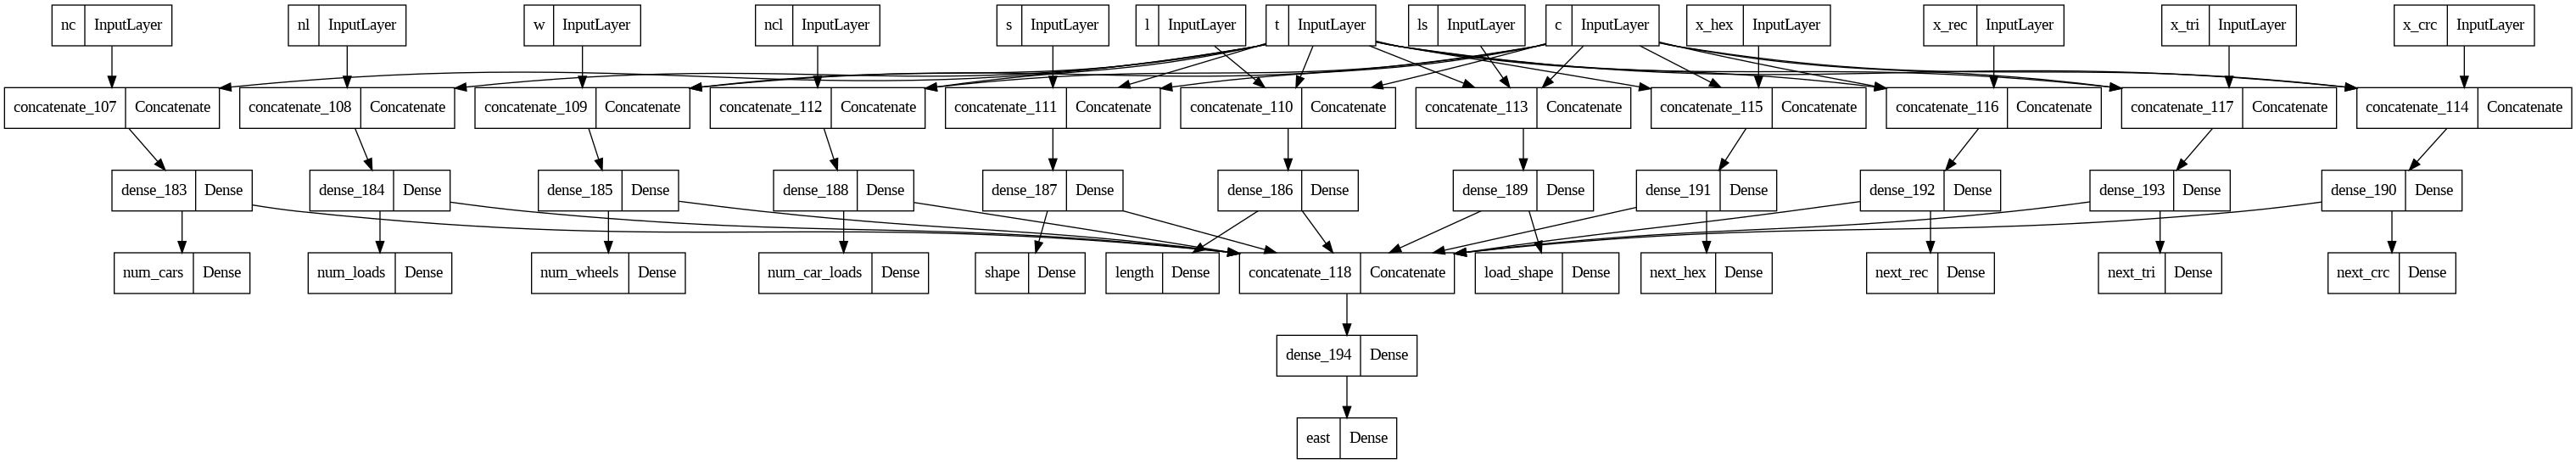

In [ ]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

### Data Augmentation

In [ ]:
df = read_data()
cols = [
    [
        c
        for c in df.columns
        if not (str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1]) == n)
    ]
    for n in range(1, 5)
]

data = [df[col] for col in cols]
for c, df in enumerate(data):
    df.columns = [
        name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns
    ]
    df["car"] = c + 1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data["train"] = data.pop("index")
data.T[0]


Number_of_cars                   4
Number_of_different_loads        2
num_wheels                     2.0
length                           1
shape                            6
num_loads                      1.0
load_shape                       2
Rectangle_next_to_rectangle      0
Rectangle_next_to_triangle       1
Rectangle_next_to_hexagon        0
Rectangle_next_to_circle         0
Triangle_next_to_triangle        0
Triangle_next_to_hexagon         0
Triangle_next_to_circle          0
Hexagon_next_to_hexagon          0
Hexagon_next_to_circle           0
Circle_next_to_circle            0
Class_attribute                  0
car                              1
train                            0
Name: 0, dtype: object

### Train

In [ ]:
def sort_inputs(X):
    t = X["train"].T
    c = X["car"].T
    w = X["num_wheels"].T
    l = X["length"].T
    s = X["shape"].T
    nc = X["Number_of_cars"].T
    ls = X["load_shape"].T
    nl = X["Number_of_different_loads"].T
    ncl = X["num_loads"].T
    x_crc = np.sum(X[[col for col in X if col.endswith("circle")]], axis=1).T
    x_hex = np.sum(X[[col for col in X if col.endswith("hexagon")]], axis=1).T
    x_rec = np.sum(X[[col for col in X if col.endswith("rectangle")]], axis=1).T
    x_tri = np.sum(X[[col for col in X if col.endswith("triangle")]], axis=1).T

    return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]


def split(data, val_train):
    x_train = data.query(f"train != {val_train}")
    x_test = data.query(f"train == {val_train}")
    y_train = np.array(x_train.pop("Class_attribute"))
    y_test = np.array(x_test.pop("Class_attribute"))
    x_train = sort_inputs(x_train)
    x_test = sort_inputs(x_test)

    return x_train, x_test, y_train, y_test


In [ ]:
# Separar os dados em 70% para treinamento e 30% para teste
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Adicionar uma coluna 'train' para indicar se o dado é de treinamento ou teste
train_data['train'] = 1
test_data['train'] = 0

# Concatenar os dados de treinamento e teste de volta em um único DataFrame
data = pd.concat([train_data, test_data])

# Chamar a função split para obter os conjuntos de treinamento e teste
x_train, x_test, y_train, y_test = split(data, val_train=0)

# Compilar o modelo
metanet.compile(optimizer=RAdam(), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = metanet.fit(
    x_train,
    [y_train]*12,  # Assumindo que todas as saídas têm o mesmo y_train
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Avaliar o modelo
loss, *metrics = metanet.evaluate(x_test, [y_test]*12)

print(f"Loss: {loss}")
print("Metrics:", metrics)


Train on 168 samples, validate on 42 samples
Epoch 1/100
168/168 [==============================] - 12s 70ms/sample - loss: 14.3552 - num_cars_loss: 1.4916 - num_loads_loss: 1.2049 - num_wheels_loss: 0.8212 - length_loss: 0.9426 - shape_loss: 2.3465 - num_car_loads_loss: 0.6549 - load_shape_loss: 0.6610 - next_crc_loss: 0.7336 - next_hex_loss: 1.2748 - next_rec_loss: 0.6629 - next_tri_loss: 0.9075 - east_loss: 2.6196 - num_cars_accuracy: 0.3155 - num_loads_accuracy: 0.3155 - num_wheels_accuracy: 0.6845 - length_accuracy: 0.3155 - shape_accuracy: 0.3155 - num_car_loads_accuracy: 0.6845 - load_shape_accuracy: 0.6310 - next_crc_accuracy: 0.6845 - next_hex_accuracy: 0.3155 - next_rec_accuracy: 0.6845 - next_tri_accuracy: 0.3155 - east_accuracy: 0.6845 - val_loss: 14.2626 - val_num_cars_loss: 1.1311 - val_num_loads_loss: 0.9902 - val_num_wheels_loss: 1.2769 - val_length_loss: 0.8599 - val_shape_loss: 1.8116 - val_num_car_loads_loss: 0.7215 - val_load_shape_loss: 0.9578 - val_next_crc_loss: 

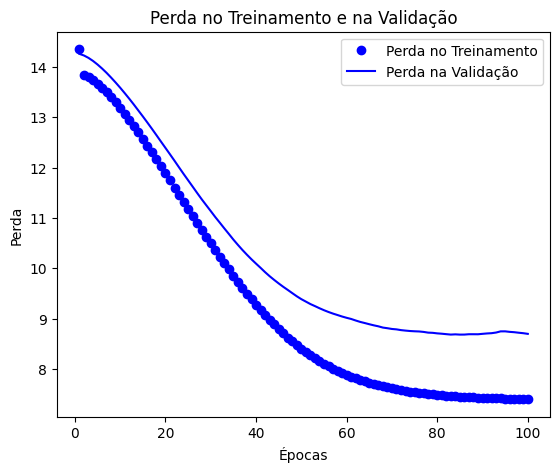

In [ ]:
# Plotar o treinamento
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# Plotar a perda (loss)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Perda no Treinamento')
plt.plot(epochs, val_loss, 'b', label='Perda na Validação')
plt.title('Perda no Treinamento e na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

#Cross validation, 1) 1.b

In [ ]:
from sklearn.model_selection import KFold

# Configuração para cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1
all_scores = []
histories = [] # Initialize a list to store history objects

for train_index, test_index in kf.split(X):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Marcar os dados de treinamento e teste
    x_train['train'] = 1
    x_test['train'] = 0

    # Concatenar os dados de treinamento e teste de volta em um único DataFrame
    data_fold = pd.concat([x_train, y_train])

    # Obter os conjuntos de treinamento e teste com a função split
    x_train_fold, x_test_fold, y_train_fold, y_test_fold = split(data, val_train=0)

    # Definir e compilar o modelo
    metanet, east, rules = model_2()
    metanet.compile(optimizer=RAdam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    history = metanet.fit(
        x_train_fold,
        [y_train_fold]*12,  # Assumindo que todas as saídas têm o mesmo y_train
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    histories.append(history) # Append history object to the list

    # Avaliar o modelo
    scores = metanet.evaluate(x_test_fold, [y_test_fold]*12, verbose=0)
    all_scores.append(scores)
    print(f'Fold {fold_no} - Loss: {scores[0]} - Accuracy: {scores[-1]}')
    fold_no += 1

# Calcular e imprimir as médias das métricas
average_scores = np.mean(all_scores, axis=0)
print(f'Average Loss: {average_scores[0]} - Average Accuracy: {average_scores[-1]}')

# Plotar os resultados
plt.figure(figsize=(14, 5))

# Perda (Loss)
plt.subplot(1, 2, 1)
for i, history in enumerate(histories): # Iterate over the stored history objects
    plt.plot(history.history['loss'], label=f'Fold {i+1}')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Acurácia (Accuracy)
plt.subplot(1, 2, 2)
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Fold {i+1}')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

Train on 168 samples, validate on 42 samples
Epoch 1/100
168/168 [==============================] - 19s 114ms/sample - loss: 10.3816 - num_cars_loss: 0.6457 - num_loads_loss: 1.4123 - num_wheels_loss: 0.5982 - length_loss: 0.8426 - shape_loss: 0.8201 - num_car_loads_loss: 0.6141 - load_shape_loss: 0.8442 - next_crc_loss: 0.6406 - next_hex_loss: 0.7564 - next_rec_loss: 1.8421 - next_tri_loss: 0.6752 - east_loss: 0.7471 - num_cars_accuracy: 0.6845 - num_loads_accuracy: 0.2917 - num_wheels_accuracy: 0.6845 - length_accuracy: 0.3155 - shape_accuracy: 0.3571 - num_car_loads_accuracy: 0.6845 - load_shape_accuracy: 0.4762 - next_crc_accuracy: 0.6607 - next_hex_accuracy: 0.3274 - next_rec_accuracy: 0.3155 - next_tri_accuracy: 0.5774 - east_accuracy: 0.3452 - val_loss: 9.9921 - val_num_cars_loss: 0.9070 - val_num_loads_loss: 1.1144 - val_num_wheels_loss: 0.7893 - val_length_loss: 0.7621 - val_shape_loss: 0.7616 - val_num_car_loads_loss: 0.7251 - val_load_shape_loss: 0.7150 - val_next_crc_loss: 

In [ ]:
hists = dict()
question_2_names = [
    "Train",
    "Output of flat network",
    "Desired output",
    "Class",
]
question_2 = {name: [] for name in question_2_names}

for validation_i in tqdm.tqdm(range(0, 10)):
    x_train, x_test, y_train, y_test = split(data, validation_i)
    metanet, east, rules = model_2()

    x_train = [np.asarray(x).astype(float) for x in x_train]
    y_train = np.asarray(y_train).astype(float)
    x_test = [np.asarray(x).astype(float) for x in x_test]
    y_test = np.asarray(y_test).astype(float)

    east.compile(
        loss=binary_crossentropy, optimizer=RAdam(), metrics=["mse", "binary_accuracy"]
    )
    hist = east.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=100,
        verbose=1,
    )
    hists[validation_i] = hist

    question_2["Train"].append(validation_i)
    question_2["Output of flat network"].append(east.predict(x_test)[0][0])
    question_2["Desired output"].append(y_test[0])
    question_2["Class"].append(str_att["Class_attribute"][int(y_test[0])])


  0%|          | 0/10 [00:00<?, ?it/s]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 7s 22ms/sample - loss: 2.7630 - mse: 0.3539 - binary_accuracy: 0.6081 - val_loss: 0.2585 - val_mse: 0.0551 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 569us/sample - loss: 1.4285 - mse: 0.3275 - binary_accuracy: 0.6622 - val_loss: 0.2539 - val_mse: 0.0532 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 601us/sample - loss: 0.5683 - mse: 0.1876 - binary_accuracy: 0.7331 - val_loss: 0.2481 - val_mse: 0.0509 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 471us/sample - loss: 0.4622 - mse: 0.1529 - binary_accuracy: 0.7770 - val_loss: 0.2341 - val_mse: 0.0458 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 409us/sample - loss: 0.4375 - mse: 0.1418 - binary_accuracy: 0.7872 - val_loss: 0.2105 - val_mse: 0.0378 - val_binary_accuracy:

 10%|█         | 1/10 [00:49<07:29, 49.97s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 6s 22ms/sample - loss: 0.8823 - mse: 0.3387 - binary_accuracy: 0.2534 - val_loss: 0.7602 - val_mse: 0.2834 - val_binary_accuracy: 0.0000e+00
Epoch 2/100
296/296 [==============================] - 0s 539us/sample - loss: 0.7843 - mse: 0.2949 - binary_accuracy: 0.1385 - val_loss: 0.7423 - val_mse: 0.2745 - val_binary_accuracy: 0.0000e+00
Epoch 3/100
296/296 [==============================] - 0s 579us/sample - loss: 0.7336 - mse: 0.2700 - binary_accuracy: 0.3311 - val_loss: 0.7208 - val_mse: 0.2638 - val_binary_accuracy: 0.5000
Epoch 4/100
296/296 [==============================] - 0s 618us/sample - loss: 0.7117 - mse: 0.2592 - binary_accuracy: 0.4459 - val_loss: 0.7040 - val_mse: 0.2554 - val_binary_accuracy: 0.7500
Epoch 5/100
296/296 [==============================] - 0s 610us/sample - loss: 0.7027 - mse: 0.2547 - binary_accuracy: 0.5236 - val_loss: 0.6940 - val_mse: 0.2504 - val_binary_a

 20%|██        | 2/10 [01:33<06:11, 46.47s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 7s 25ms/sample - loss: 1.3065 - mse: 0.3672 - binary_accuracy: 0.4865 - val_loss: 0.6152 - val_mse: 0.2115 - val_binary_accuracy: 0.7500
Epoch 2/100
296/296 [==============================] - 0s 395us/sample - loss: 0.9901 - mse: 0.3586 - binary_accuracy: 0.4493 - val_loss: 0.5679 - val_mse: 0.1883 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 355us/sample - loss: 0.7064 - mse: 0.2562 - binary_accuracy: 0.5507 - val_loss: 0.5076 - val_mse: 0.1592 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 381us/sample - loss: 0.5983 - mse: 0.2044 - binary_accuracy: 0.7027 - val_loss: 0.4715 - val_mse: 0.1421 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 386us/sample - loss: 0.6169 - mse: 0.2134 - binary_accuracy: 0.6791 - val_loss: 0.4605 - val_mse: 0.1369 - val_binary_accuracy:

 30%|███       | 3/10 [02:19<05:22, 46.09s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 6s 22ms/sample - loss: 3.3608 - mse: 0.4906 - binary_accuracy: 0.3682 - val_loss: 2.4961 - val_mse: 0.8329 - val_binary_accuracy: 0.0000e+00
Epoch 2/100
296/296 [==============================] - 0s 397us/sample - loss: 1.4675 - mse: 0.4973 - binary_accuracy: 0.3378 - val_loss: 2.3824 - val_mse: 0.8148 - val_binary_accuracy: 0.0000e+00
Epoch 3/100
296/296 [==============================] - 0s 595us/sample - loss: 1.3752 - mse: 0.4785 - binary_accuracy: 0.3378 - val_loss: 2.2269 - val_mse: 0.7870 - val_binary_accuracy: 0.0000e+00
Epoch 4/100
296/296 [==============================] - 0s 543us/sample - loss: 1.2565 - mse: 0.4521 - binary_accuracy: 0.3378 - val_loss: 2.0578 - val_mse: 0.7524 - val_binary_accuracy: 0.0000e+00
Epoch 5/100
296/296 [==============================] - 0s 545us/sample - loss: 1.1272 - mse: 0.4191 - binary_accuracy: 0.3378 - val_loss: 1.8799 - val_mse: 0.7104 - val_

 40%|████      | 4/10 [03:05<04:36, 46.16s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 7s 25ms/sample - loss: 0.9901 - mse: 0.3380 - binary_accuracy: 0.3784 - val_loss: 1.0152 - val_mse: 0.4046 - val_binary_accuracy: 0.0000e+00
Epoch 2/100
296/296 [==============================] - 0s 447us/sample - loss: 0.6998 - mse: 0.2537 - binary_accuracy: 0.4493 - val_loss: 0.9694 - val_mse: 0.3835 - val_binary_accuracy: 0.0000e+00
Epoch 3/100
296/296 [==============================] - 0s 403us/sample - loss: 0.6946 - mse: 0.2507 - binary_accuracy: 0.5439 - val_loss: 0.9193 - val_mse: 0.3600 - val_binary_accuracy: 0.0000e+00
Epoch 4/100
296/296 [==============================] - 0s 418us/sample - loss: 0.6849 - mse: 0.2464 - binary_accuracy: 0.5372 - val_loss: 0.8747 - val_mse: 0.3389 - val_binary_accuracy: 0.0000e+00
Epoch 5/100
296/296 [==============================] - 0s 425us/sample - loss: 0.6795 - mse: 0.2445 - binary_accuracy: 0.4899 - val_loss: 0.8328 - val_mse: 0.3187 - val_

 50%|█████     | 5/10 [03:50<03:47, 45.60s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 7s 22ms/sample - loss: 0.6877 - mse: 0.2473 - binary_accuracy: 0.6622 - val_loss: 0.6738 - val_mse: 0.2403 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 398us/sample - loss: 0.6866 - mse: 0.2468 - binary_accuracy: 0.6622 - val_loss: 0.6676 - val_mse: 0.2373 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 392us/sample - loss: 0.6824 - mse: 0.2447 - binary_accuracy: 0.6622 - val_loss: 0.6601 - val_mse: 0.2336 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 430us/sample - loss: 0.6784 - mse: 0.2427 - binary_accuracy: 0.6622 - val_loss: 0.6437 - val_mse: 0.2255 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 399us/sample - loss: 0.6764 - mse: 0.2417 - binary_accuracy: 0.6622 - val_loss: 0.6106 - val_mse: 0.2091 - val_binary_accuracy:

 60%|██████    | 6/10 [04:37<03:03, 45.93s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 8s 26ms/sample - loss: 0.6756 - mse: 0.2434 - binary_accuracy: 0.6149 - val_loss: 0.6924 - val_mse: 0.2496 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 429us/sample - loss: 0.6153 - mse: 0.2131 - binary_accuracy: 0.7196 - val_loss: 0.6921 - val_mse: 0.2495 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 441us/sample - loss: 0.6048 - mse: 0.2074 - binary_accuracy: 0.7635 - val_loss: 0.6917 - val_mse: 0.2493 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 512us/sample - loss: 0.5966 - mse: 0.2035 - binary_accuracy: 0.7770 - val_loss: 0.6911 - val_mse: 0.2490 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 439us/sample - loss: 0.5899 - mse: 0.2006 - binary_accuracy: 0.7770 - val_loss: 0.6863 - val_mse: 0.2466 - val_binary_accuracy:

 70%|███████   | 7/10 [05:24<02:19, 46.44s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 7s 23ms/sample - loss: 0.7432 - mse: 0.2708 - binary_accuracy: 0.6622 - val_loss: 0.5378 - val_mse: 0.1741 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 393us/sample - loss: 0.7144 - mse: 0.2591 - binary_accuracy: 0.6622 - val_loss: 0.5078 - val_mse: 0.1601 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 429us/sample - loss: 0.6836 - mse: 0.2451 - binary_accuracy: 0.6622 - val_loss: 0.4459 - val_mse: 0.1313 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 429us/sample - loss: 0.6622 - mse: 0.2352 - binary_accuracy: 0.6622 - val_loss: 0.4531 - val_mse: 0.1348 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 487us/sample - loss: 0.6447 - mse: 0.2271 - binary_accuracy: 0.6622 - val_loss: 0.4354 - val_mse: 0.1268 - val_binary_accuracy:

 80%|████████  | 8/10 [06:14<01:35, 47.69s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 8s 27ms/sample - loss: 1.7207 - mse: 0.3200 - binary_accuracy: 0.5878 - val_loss: 0.1918 - val_mse: 0.0354 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 448us/sample - loss: 0.5672 - mse: 0.1961 - binary_accuracy: 0.6791 - val_loss: 0.2128 - val_mse: 0.0422 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 442us/sample - loss: 0.5534 - mse: 0.1847 - binary_accuracy: 0.7601 - val_loss: 0.2091 - val_mse: 0.0408 - val_binary_accuracy: 1.0000
Epoch 4/100
296/296 [==============================] - 0s 426us/sample - loss: 0.5352 - mse: 0.1782 - binary_accuracy: 0.7500 - val_loss: 0.1772 - val_mse: 0.0304 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 463us/sample - loss: 0.5205 - mse: 0.1751 - binary_accuracy: 0.6993 - val_loss: 0.1613 - val_mse: 0.0255 - val_binary_accuracy:

 90%|█████████ | 9/10 [07:06<00:48, 48.77s/it]

Train on 296 samples, validate on 4 samples
Epoch 1/100
296/296 [==============================] - 9s 29ms/sample - loss: 1.0001 - mse: 0.3149 - binary_accuracy: 0.6115 - val_loss: 0.6619 - val_mse: 0.2344 - val_binary_accuracy: 1.0000
Epoch 2/100
296/296 [==============================] - 0s 444us/sample - loss: 0.7649 - mse: 0.2825 - binary_accuracy: 0.5946 - val_loss: 0.6675 - val_mse: 0.2372 - val_binary_accuracy: 1.0000
Epoch 3/100
296/296 [==============================] - 0s 485us/sample - loss: 0.7514 - mse: 0.2770 - binary_accuracy: 0.5912 - val_loss: 0.6749 - val_mse: 0.2409 - val_binary_accuracy: 0.7500
Epoch 4/100
296/296 [==============================] - 0s 481us/sample - loss: 0.7370 - mse: 0.2709 - binary_accuracy: 0.5946 - val_loss: 0.6814 - val_mse: 0.2441 - val_binary_accuracy: 1.0000
Epoch 5/100
296/296 [==============================] - 0s 475us/sample - loss: 0.7232 - mse: 0.2646 - binary_accuracy: 0.6622 - val_loss: 0.6855 - val_mse: 0.2462 - val_binary_accuracy:

100%|██████████| 10/10 [08:00<00:00, 48.04s/it]


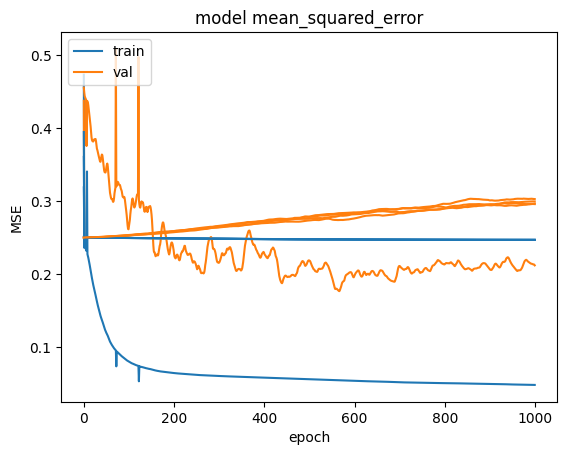

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


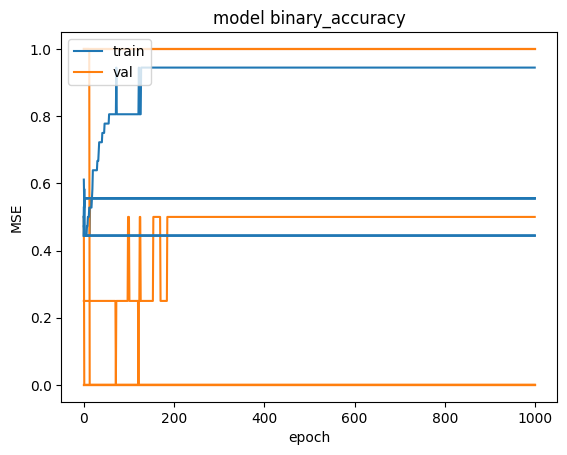

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
t2 = pd.DataFrame.from_dict(question_2).round(2)
t2["Cars Accuracy"] = [hists[i].history["binary_accuracy"][-1] for i in range(0, 10)]
t2 = t2.reindex(
    columns=[
        "Train",
        "Cars Accuracy",
        "Output of flat network",
        "Desired output",
        "Class",
    ]
)
t2


,Train,Cars Accuracy,Output of flat network,Desired output,Class
0,0,0.555556,NaN,1,east
1,1,0.555556,0.46,1,east
2,2,0.555556,NaN,1,east
3,3,0.555556,0.45,1,east
4,4,0.944444,0.43,1,east
5,5,0.555556,0.54,0,west
6,6,0.555556,0.55,0,west
7,7,0.444444,NaN,0,west
8,8,0.444444,NaN,0,west
9,9,0.444444,NaN,0,west
